In [2]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Any, Dict, List, Tuple
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [3]:
# Firstly, we define a class we can draw a graph in convinient way
class GraphModel:
    
    n_nodes: int
    edges: List[Tuple[int, int]]
    graph: nx.Graph
          
    def __init__(self, n_nodes, edges, weights, distancies, qaoa_solve=None):
        
        self.n_nodes = n_nodes
        self.edges = edges
        self.weights = weights
        self.distancies  = distancies
        self.graph = nx.Graph()
        self.graph.add_nodes_from(np.arange(0,n_nodes,1))
        self.graph.add_edges_from(edges)
        #self.qaoa_solve = qaoa_solve
        
    def draw_raw_graph(self):
        
        # Generate plot of the  Graph
        colors       = ['cornflowerblue' for node in self.graph.nodes()]
        default_axes = plt.axes(frameon=False)
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)

        nx.draw_networkx_nodes(self.graph, node_color=colors, node_size=900,pos = pos, 
                    alpha=1, ax=default_axes)       
        nx.draw_networkx_edges(self.graph, pos = pos, width=8,alpha=1,ax=default_axes,
                               edge_color="tab:gray")
        nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="white")


    def draw_done_graph(self,bitstring):
        
        # Draw a graph in accordance with its bitstring
        color_map = []
        edgelist_different  = []
        edgelist_same  = []
        default_axes = plt.axes(frameon=False)
        default_axes.axis('off')
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)
        
        if bitstring == None:
            self.draw_raw_graph()
        else:
            for i in bitstring:
                if i > 0:
                    color_map.append('red')
                else: 
                    color_map.append('cornflowerblue')
#             for edge in self.edges:
#                 if bitstring[edge[0]] != bitstring[edge[1]]:
#                     edgelist_different.append(edge)
#                 else:
#                     edgelist_same.append(edge)
                    
            nx.draw_networkx_nodes(self.graph, node_color=color_map, node_size=900,pos = pos, 
                    alpha=1, ax=default_axes)       
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = self.edges, 
                                   width=8,alpha=1,ax=default_axes,edge_color="tab:grey")
#             nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_different,
#                                    width=8,alpha=1,ax=default_axes, edge_color="tab:red")
            nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="white")
    
    def connections(self, node): 
        connection_list = []
        for edge in self.edges:
                if (edge[0] == node):
                    connection_list.append(edge[1])
                elif (edge[1] == node):
                    connection_list.append(edge[0])
        connection_list = list(dict.fromkeys(connection_list))
        return connection_list
    
    # This function returns all edges corresponding to certain node of the graph G    
    def find_edges(self, node): 
        connection_edges = []
        for edge in self.edges:
                if (edge[0] == node):
                    connection_edges.append(edge)
                elif (edge[1] == node):
                    connection_edges.append(edge)
        connection_edges = list(dict.fromkeys(connection_edges)) 
        return connection_edges

In [4]:
def graph_drawing(G,regime, *args, **kwargs):
    bitstring = kwargs.get('bitstring', None)
    filename = kwargs.get('filename', None)
    figure, axes = plt.subplots(frameon=False)
    axes.axis('off')
    # Turn off tick labels
    req_dpi = 100 
    figure.set_size_inches(500 / float(req_dpi),  
                           500 / float(req_dpi)) 
    if regime == 'raw':
        G.draw_raw_graph()
    elif regime == 'done':
        G.draw_done_graph(bitstring)
    else:
        raise ValueError('Regime is wrong')
        
    figure.savefig(filename, format='png',
               transparent=True, dpi=req_dpi) 

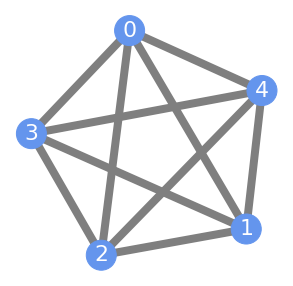

In [197]:
# Example of drawing method of the class GrapgModel
n_nodes = 5
E = [(0,1),(0,2),(0,3), (0,4),(1,2),(1,3), (1,4), (2,3), (2,4),(3,4) ]
weghts_list = [1,2,7,4,5]
distancies_list = [1,2,2,1,1,2,2,1,2,1]
G = GraphModel(n_nodes, E, weghts_list, distancies_list )
graph_drawing(G,'raw',filename = 'dummy_graph.png')

# n_nodes = 3
# E = [(0,1),(0,2),(1,2)]
# weghts_list = [5,5,100]
# distancies_list = [1,1,10]
# G = GraphModel(n_nodes, E, weghts_list, distancies_list )
# graph_drawing(G,'raw',filename = 'dummy_graph.png')

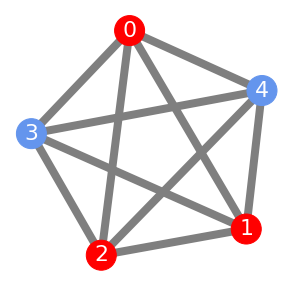

In [232]:
graph_drawing(G,'done',bitstring = [1,1,1,0,0],filename = 'dummy_graph_option.png')
# graph_drawing(G,'done',bitstring = [1,0,1],filename = 'dummy_graph_option.png')

In [199]:
G.weights

[1, 2, 7, 4, 5]

In [200]:
len(G.distancies) == len(G.edges)

True

## Circuit construction

Calculation of the hamiltonian coefficients 

\begin{equation}
H =  \sum_{i=1}^{N} (h_i - \sum_{j \not= i} g_{ij}) \, Z_i + \sum_{i<j} g_{ij} Z_iZ_j
 \end{equation}

 where we have defined $h_i = Vw_i$ and $g_{ij} = \frac{1}{4} (2w_i w_j+d_{ij}) $
 
 $k_i = (h_i - \sum_{j \not= i} g_{ij}) $


In [201]:
G.weights

[1, 2, 7, 4, 5]

In [202]:
# Calculation the parameters 
# eps = 1 # defining the penalty term 
V = 10 # the total volume of the vessel

h = []
for weight in G.weights:
    h.append(V*weight)
        
# g = [] # 1-1 correspondabce between edge and q_ij
# for edge in G.edges:
#     index = G.edges.index(edge)
#     q.append(0.25*(G.distancies[index]
#                    + 2*G.weights[G.edges[index][0]]*G.weights[G.edges[index][1]]))
print(h)

g = np.zeros((G.n_nodes,G.n_nodes))
for i in range(0,G.n_nodes):
    for j in range(0,G.n_nodes):
        d = 0
        if (i,j) in G.edges:
            d = G.distancies[G.edges.index((i,j))]
        if (j,i) in G.edges:
            d = G.distancies[G.edges.index((j,i))]
        g[i,j] += 0.25*(2*G.weights[i]*G.weights[j] + d)
print(h[0]-g[0,0])    
    
k = []
for i in range(0,G.n_nodes):
    g_part = 0 
    for j in range(0,G.n_nodes):
        if i!=j:
            g_part += g[i,j]       
    k.append(h[i] - g_part)
k

[10, 20, 70, 40, 50]
9.5


[-0.5, 1.5, 26.5, 8.5, 13.5]

In [203]:
print("g = \n",g,'\n',"h = ",h,'\n','k = ',k)

g = 
 [[ 0.5   1.25  4.    2.5   2.75]
 [ 1.25  2.    7.25  4.5   5.5 ]
 [ 4.    7.25 24.5  14.25 18.  ]
 [ 2.5   4.5  14.25  8.   10.25]
 [ 2.75  5.5  18.   10.25 12.5 ]] 
 h =  [10, 20, 70, 40, 50] 
 k =  [-0.5, 1.5, 26.5, 8.5, 13.5]


In [204]:
for edge in G.edges:  # pairs of nodes
    print(g[edge[0], edge[1]], edge[0], edge[1])

1.25 0 1
4.0 0 2
2.5 0 3
2.75 0 4
7.25 1 2
4.5 1 3
5.5 1 4
14.25 2 3
18.0 2 4
10.25 3 4


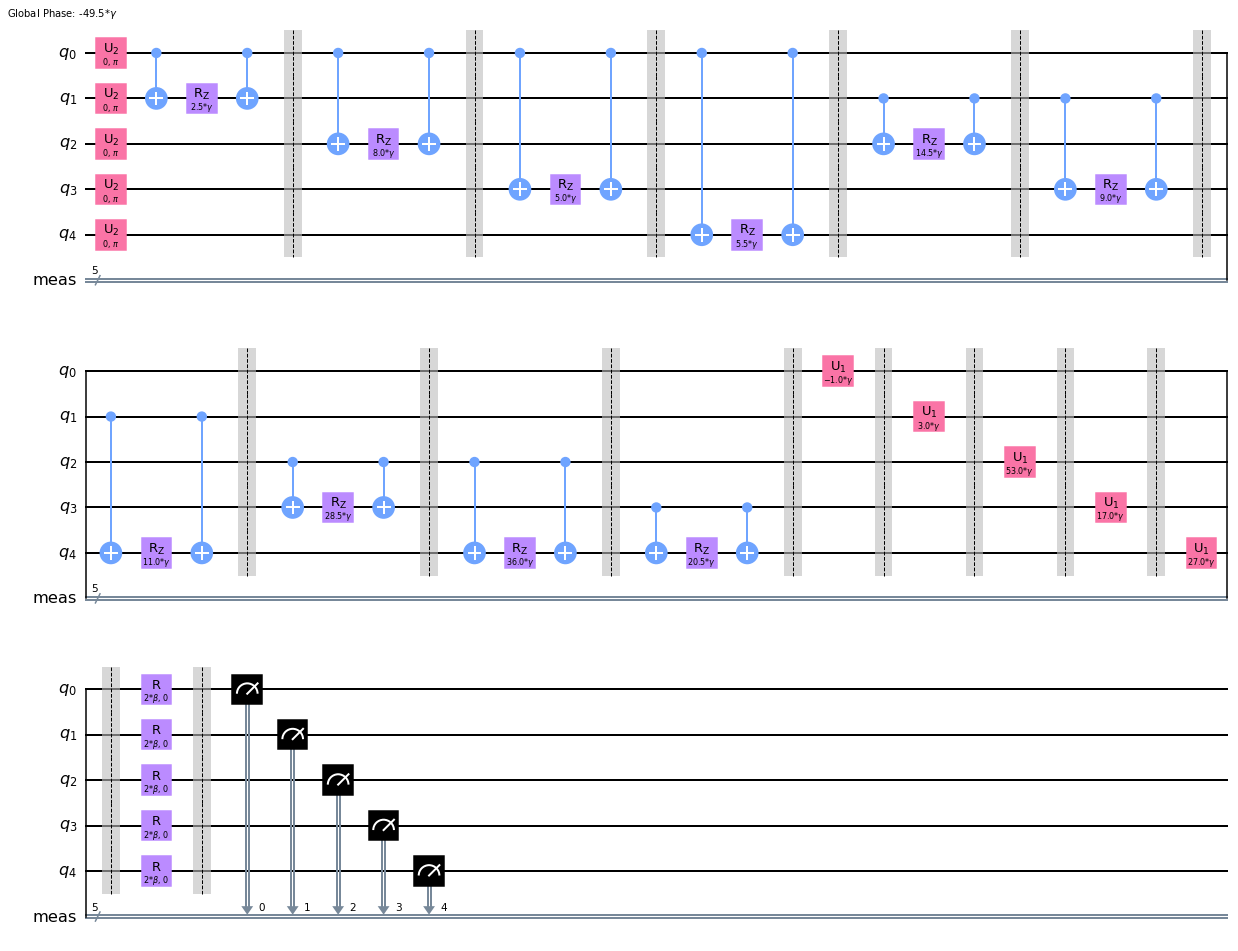

In [205]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

nqubits = n_nodes
# Drawing the circuit for p=1
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p_1 = QuantumCircuit(nqubits)
for edge in G.edges:  # pairs of nodes
    qc_p_1.rzz(2 * gamma * g[edge[0], edge[1]], edge[0], edge[1])
    qc_p_1.barrier()

qc_p_2 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_p_2.rz(2 * gamma * k[i],i)
    qc_p_2.barrier()
    
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p_1, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p_2, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.measure_all()
qc_qaoa.decompose().decompose().draw("mpl")

In [206]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

In [207]:
for edge in G.edges:  # pairs of nodes
    print(2*g[edge[0], edge[1]])
        

2.5
8.0
5.0
5.5
14.5
9.0
11.0
28.5
36.0
20.5


In [208]:
x = "00101"
x = list(map(int,list(x)))
x

[0, 0, 1, 0, 1]

Here we create the QAOA model to **minimize** the function: 

\begin{equation}
C(\vec{x}) = -2V \sum_{i=1}^{N} w_i z_i + \sum_{i<j}^N (2 w_i w_j + d_{ij})\, z_i z_j
 \end{equation} 

In [213]:
def problem_obj(x, G):

#     Given a bitstring as a solution, this function returns
#     the value of C(x)

#     Args:
#         x: str
#            solution bitstring

#         G: networkx graph

                    
    obj = 0
    x = list(map(int,list(x))) # the order does not 
#     x = list(reversed(x))#  we  changed the order here
    for i in range(0,G.n_nodes):
#         print(p,x)
        obj -= 2*V*h[i]*x[i]
        for j in range(i+1,G.n_nodes):
                obj += 4*x[i]*x[j]*g[i,j]      
    return obj

def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
#         print(counts.items())
        obj = problem_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

#     """
#     Creates a parametrized qaoa circuit

#     Args:  
#         G: networkx graph
#         theta: list
#                unitary parameters

#     Returns:
#         qc: qiskit circuit
#     """

    nqubits = G.n_nodes
    depth = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:depth]
    gamma = theta[depth:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, depth):

        # problem unitary
        for edge in G.edges:  # pairs of nodes
            qc.rzz(2 * gamma[irep] * g[edge[0], edge[1]], edge[0], edge[1])
            qc.barrier()
        
        for i in range(0, nqubits):
            qc.rz(2 * gamma[irep] * k[i],i)
        
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, backend):

#         """
#         Runs parametrized circuit

#         Args:
#             G: networkx graph
#             p: int,
#                Number of repetitions of unitaries
#         """

#     backend = Aer.get_backend('qasm_simulator')
#     backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc,nshots=backend.shots).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

def optimization(G,initial_parameters,backend):
    expectation = get_expectation(G,backend)

    res = minimize(expectation, initial_parameters, method='COBYLA')
    return res

In [229]:
depth = 2
initial_parameters = [1.0,1.0]*depth

backend = Aer.get_backend('qasm_simulator')
backend.shots = 2048
qc_res = create_qaoa_circ(G, optimization(G,initial_parameters,backend).x)

# model = QAOA(G,initial_parameters)
# counts = model.counts

In [230]:
counts = backend.run(qc_res, shots=1024).result().get_counts()
counts

{'11010': 15,
 '01000': 9,
 '11001': 40,
 '00101': 18,
 '01001': 6,
 '11011': 20,
 '11101': 5,
 '10100': 70,
 '10101': 6,
 '10000': 2,
 '01011': 22,
 '00000': 22,
 '00111': 145,
 '01010': 11,
 '10001': 79,
 '01110': 43,
 '01111': 51,
 '11100': 24,
 '11110': 68,
 '00010': 70,
 '00110': 34,
 '00011': 28,
 '00100': 24,
 '10011': 25,
 '10010': 7,
 '10110': 21,
 '11111': 65,
 '01100': 13,
 '10111': 2,
 '11000': 50,
 '00001': 5,
 '01101': 24}

## Final results 

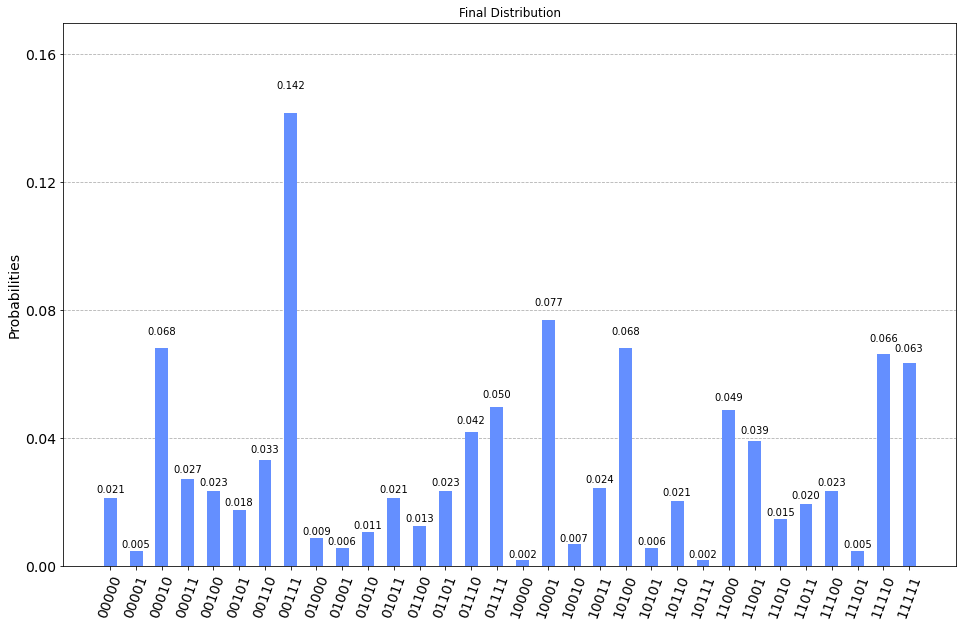

In [231]:
plot_histogram(counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None)

00111 corresponds to 0,1,2 nodes are occupied